In [1]:
# import libraries for data preprocessing

# !pip install datasets

import pandas as pd
import numpy as np
import plotly.express as px
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import torch

In [3]:
# load dataset into memory as a dataframe
ticket_df = pd.read_csv("./ticket-helpdesk-multi-lang.csv")

In [ ]:
# view the first 10 entries in the dataframe
print("First Ten entries in Ticket Dataframe: \n")
ticket_df.head(10)

First Ten entries in Ticket Dataframe: 



,queue,priority,language,subcategory,subject,text
0,ACCOUNTING,MEDIUM,EN,Customer Inquiries::Payments,Inquiry About Payment Method Update,"Dear Support Team,\n\nI would like to update t..."
1,ACCOUNTING,MEDIUM,DE,Employee Inquiries::Health and Safety,Mängel Gesundheitsbericht Anwendung,"Sehr geehrtes Support-Team, ich nutze Ihre Anw..."
2,SOFTWARE,LOW,EN,Crypto Wallets,Crypto Wallets Update Inquiry and Billing Info,"Good day, I hope everything is great on your e..."
3,ACCOUNTING,LOW,EN,Employee Inquiries::Staff Development,Possibility of Business Name Change on Next In...,"Hello team,\n\nI noticed there's a slight typo..."
4,HARDWARE,HIGH,EN,Temperature Sensor,High Priority: Temperature Sensor Not Powering Up,I urgently need assistance with my hardware te...
5,SOFTWARE,HIGH,DE,Video Marketing,Dringend - Video Marketing Software öffnet nic...,"Hallo Support-Team, nach dem letzten Update öf..."
6,SOFTWARE,HIGH,EN,Inventory Optimization,Urgent: Server not reachable with Inventory Op...,I'm unable to access our Inventory Optimizatio...
7,HARDWARE,LOW,FR,Smart-CPAP-Gerät,Demande de petite modification de la facture,"Bonjour, je suis très satisfait de mon Smart-C..."
8,HARDWARE,MEDIUM,EN,Speicherkartenleser,Card Reader Issue - Not Recognizing SD Cards,"Dear Support, my card reader is having trouble..."
9,ACCOUNTING,MEDIUM,EN,Customer Inquiries::Product Inquiries,Inquiry About Invoice for Software Development...,"Dear Support, I haven't received the invoice f..."


In [ ]:
# Get info on Dataframe attributes
print("Ticket Dataframe attributes: \n")
ticket_df.info()

Ticket Dataframe attributes: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   queue        399 non-null    object
 1   priority     399 non-null    object
 2   language     399 non-null    object
 3   subcategory  399 non-null    object
 4   subject      399 non-null    object
 5   text         399 non-null    object
dtypes: object(6)
memory usage: 18.8+ KB


In [ ]:
# get a detailed summary of what dataframe is all about
print("Tickets Dataframe Summary: \n")
ticket_df.describe(include='all')

Tickets Dataframe Summary: 



,queue,priority,language,subcategory,subject,text
count,399,399,399,399,399,399
unique,3,3,4,321,399,399
top,SOFTWARE,HIGH,EN,Customer Inquiries::Payments,Inquiry About Payment Method Update,"Dear Support Team,\n\nI would like to update t..."
freq,226,162,173,5,1,1


From the description above it can be seen that the queue has 3 distinct classes with the most prominent class being SOFTWARE, priority also has 3 distinct categories with HIGH has the most prominent/frequent. Language has 4 distinct classes with EN (English) being the most frequent while Subcategory has 321 distinct classes with Customer Inquiries::Payment being the most frequent.


Let's do some Exploratory Data Analysis to better understand the narratives in the data.

In [ ]:
# Visualize the distribution of the Queue

queue_plot = px.histogram(ticket_df, x='queue', title='Distribution of Queue Categories', color='queue')
queue_plot.show()

In [ ]:
# Visualize the distribution of the Priority

prior_plot = px.histogram(ticket_df, x='priority', title='Distribution of Priority Categories', color='priority')
prior_plot.show()

In [ ]:
# Visualize the distribution of the Language

lang_plot = px.histogram(ticket_df, x='language', title='Distribution of Language Categories', color='language')
lang_plot.show()

In [ ]:
# Visualize the distribution of the SubCategory

sub_plot = px.histogram(ticket_df, y='subcategory', title='Distribution of SubCategory Classes', color='subcategory')
sub_plot.show()

<Axes: xlabel='queue', ylabel='subcategory'>

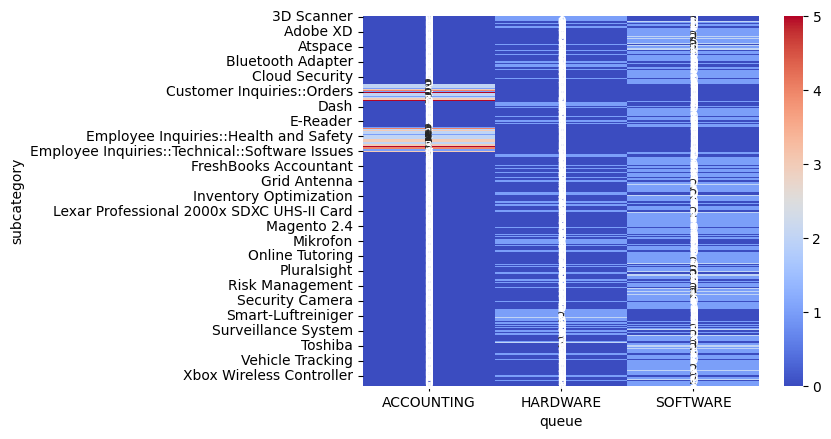

In [ ]:
# Plot a heatmap showing the relationship between queue and subcategory in the dataframe
q_sub_contingency_table = pd.crosstab(ticket_df['subcategory'], ticket_df['queue'])
sns.heatmap(q_sub_contingency_table, annot=True, cmap='coolwarm', fmt='d')

<Axes: xlabel='priority', ylabel='queue'>

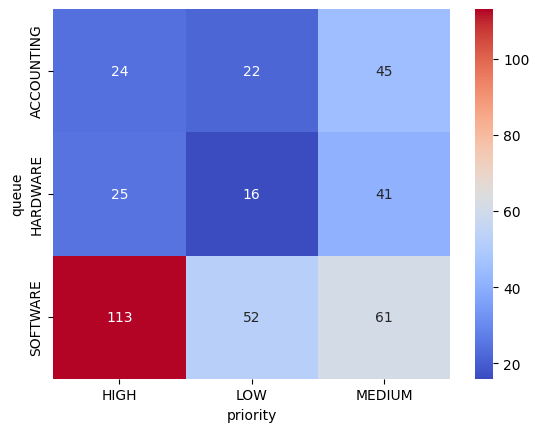

In [ ]:
# Plot a heatmap showing the relationship between queue and priority in the dataframe
q_priority_contingency_table = pd.crosstab(ticket_df['queue'], ticket_df['priority'])
sns.heatmap(q_priority_contingency_table, annot=True, cmap='coolwarm', fmt='d')

<Axes: xlabel='language', ylabel='queue'>

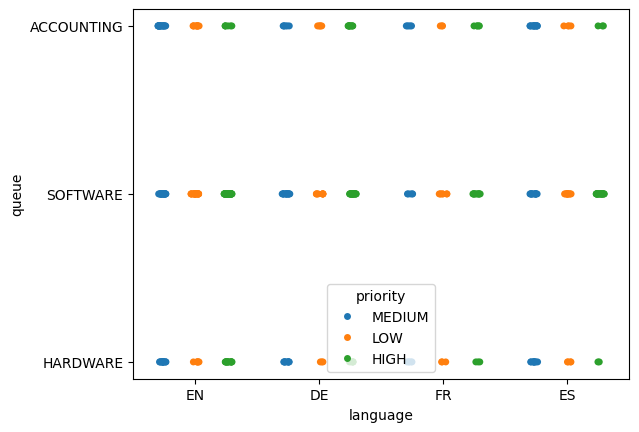

In [ ]:
# Plot a stripplot to visualize the distribution of languages across queues based on priority
sns.stripplot(x='language', y='queue', hue='priority', data=ticket_df, jitter=True, dodge=True)

From the visualizations above, it can be deduced that the SOFTWARE tickets are the most common and are mostly of HIGH priority according to the dataset. The least number of HIGH priority tickets belong to the ACCOUNTING queue. Most HARDWARE tickets are of medium priority.

Also, only a tiny proportion of subcategories are recurring thus explaining the large number of distinct categorical variables in this colun. This makes sense if you think of the subcategories as keywords gotten from the ticket content itself.

In [4]:
# Ensure all entries in text column are in string format and all lower case
ticket_df = ticket_df.dropna(subset=['text']) # drop null entries if existent
ticket_df['text'] = ticket_df['text'].str.lower()

In [5]:
# Encode Target Class queue
ticket_df['queue_enc'] = ticket_df['queue'].astype('category').cat.codes
# Get encoding mapping
q_map = dict(enumerate(ticket_df['queue'].astype('category').cat.categories))

In [6]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(ticket_df['text'], ticket_df['queue_enc'], test_size=0.2, random_state=42)

In [7]:
# Create Dataset object for HuggingFace
train_data = Dataset.from_dict({'text': X_train.tolist(), 'label': y_train.tolist()})
test_data = Dataset.from_dict({'text': X_test.tolist(), 'label': y_test.tolist()})

In [8]:
# Load pre-trained tokenizer and model
model_name = "xlm-roberta-base"  # Multilingual model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name,
        num_labels=ticket_df['queue_enc'].nunique(), id2label=q_map)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# Define  function to tokenize the text data from dataframe
def tokenizing_function(dataframe):
    return tokenizer(dataframe['text'], truncation=True, padding=True)

train_data = train_data.map(tokenizing_function, batched=True)
test_data = test_data.map(tokenizing_function, batched=True)

Map:   0%|          | 0/319 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

In [10]:
training_args = TrainingArguments(
    output_dir='./classifier/results',
    eval_strategy="epoch",
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
)

In [11]:
# Compute metrics for evaluation
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        'accuracy': (preds == p.label_ids).astype(np.float32).mean().item(),
    }

In [12]:
# Instantiate the model trainer
model_trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


In [13]:
# Train the model
model_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.997269,0.562500


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.997269,0.562500
2,No log,1.013062,0.562500


TrainOutput(global_step=80, training_loss=1.008046817779541, metrics={'train_runtime': 1959.9081, 'train_samples_per_second': 0.326, 'train_steps_per_second': 0.041, 'total_flos': 59343381352332.0, 'train_loss': 1.008046817779541, 'epoch': 2.0})

In [14]:
# Evaluate the model trainer

model_trainer.evaluate()


{'eval_loss': 1.0130621194839478,
 'eval_accuracy': 0.5625,
 'eval_runtime': 51.1786,
 'eval_samples_per_second': 1.563,
 'eval_steps_per_second': 0.195,
 'epoch': 2.0}

In [15]:
# Make Predictions With Model
predictions = model_trainer.predict(test_data)
preds = torch.tensor(predictions.predictions).argmax(axis=1)

# Show classification report
print(classification_report(y_test, preds, target_names=[q_map[i] for i in range(len(q_map))]))

              precision    recall  f1-score   support

  ACCOUNTING       0.00      0.00      0.00        17
    HARDWARE       0.00      0.00      0.00        18
    SOFTWARE       0.56      1.00      0.72        45

    accuracy                           0.56        80
   macro avg       0.19      0.33      0.24        80
weighted avg       0.32      0.56      0.40        80



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
# Show confusion matrix
cm = confusion_matrix(y_test, preds)
fig_cm = px.imshow(cm, text_auto=True, labels=dict(x="Predicted", y="Actual"), x=list(q_map.values()), y=list(q_map.values()))
fig_cm.update_layout(title="Confusion Matrix")
fig_cm.show()

In [17]:
# Save the model
model_trainer.save_model("./classifier/model")